In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from scipy.special import erf
import pandas as pd

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [2]:
def prepare_mother_list(filepath, Nevents=-1, random_state=1, make_plot=True, testratio=0.15):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2']
    data.set_index('Event', inplace=True)
    
    # select only Nevents number of events
    Nevents = int(Nevents/(1-testratio))
    if len(data) < Nevents:
        print('WARNING: asking for {0} + {1} = {2} events (training + testing), but only {3} provided.'
              'Either reduce Nevents or the testratio (default=0.15)'.format(
                Nevents*(1-testratio), Nevents*testratio, Nevents, len(data)))
    if 0 < Nevents < len(data):
        data = data.sample(Nevents, random_state=random_state)
    
    # define training and testing subset
    data['dataset'] = 'training'
    testingset = data.sample(int(len(data)*testratio), random_state=0)
    testingset.dataset = 'testing'
    data.update(testingset)
    
    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data.drop(columns='dataset')) | (data.drop(columns='dataset')==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    # make mJ1 > mJ2 (and also swap tau_21 accordingly)
    data['mmax'] = np.max(data[['mJ1', 'mJ2']], axis=1)
    data['mmin'] = np.min(data[['mJ1', 'mJ2']], axis=1)
    J1ismax = data.mJ1 == data.mmax
    data['tau21max'] = data[J1ismax].tau21J1
    data.loc[~J1ismax, 'tau21max'] = data[~J1ismax].tau21J2
    data['tau21min'] = data[J1ismax].tau21J2
    data.loc[~J1ismax, 'tau21min'] = data[~J1ismax].tau21J1
    data.mJ1 = data.mmax
    data.mJ2 = data.mmin
    data.tau21J1 = data.tau21max
    data.tau21J2 = data.tau21min
    data['diffm'] = data.mmax - data.mmin
    
    data.drop(columns = ['mmax', 'mmin', 'tau21max', 'tau21min', 'mJ2'], inplace=True)
    
    print('retrieved array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            hist_range = None
            bins=20
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
            elif feature == 'diffm':
                hist_range = (0, 400)
            elif feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True, bins=bins, range=hist_range)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.savefig('{}_distributions.png'.format(filepath))
        plt.show()

    return data

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv, ignore=None):
    if not ignore is None:
        if type(ignore) == str:
            ignore = [ignore]
        ignored = list_by_minv.loc[:, ignore]
        list_by_minv = list_by_minv.drop(columns = ignore)
    SR = (list_by_minv.mJJ > (M-deltaM)) & (list_by_minv.mJJ < (M+deltaM))

    #put the data on a unit hypercube and remove the edges
    hypercubemargin = 0.05
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    hcube = (list_by_minv - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # remove edges
    edge = (hcube < hypercubemargin).any(axis=1) | (hcube > 1-hypercubemargin).any(axis=1)
    print('efficiency in SR when cutting edges of hypercube: {:.2f}'.format(
        len(hcube[SR & ~edge])/len(hcube[SR])))
    if not ignore is None:
        hcube = pd.concat([hcube, ignored], axis=1)
    
    SBdata = hcube[~SR & ~edge].copy()
    SRdata = hcube[SR & ~edge].copy()
    SR_masses = list_by_minv[SR & ~edge].mJJ.values
    return SBdata, SRdata, SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg])
    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            hist_range = None
            bins = 20
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
            elif feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
                
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background', range=hist_range, bins=bins)
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal', range=hist_range, bins=bins)
            axs[divmod(i, 3)].set_yscale('log')
            axs[divmod(i, 3)].set_ylabel('# events, stacked')
            if i == 0:
                axs[divmod(i, 3)].legend()
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.show()
    
    return combined

In [3]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [4]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [5]:
def build_iflow(ndims,lr, weight_decay):
    min_mask = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    for i in range(3):
        masks = np.concatenate((masks, min_mask))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=16,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=1000, decay_rate=0.5)
    optimizer = tfa.optimizers.AdamW(weight_decay, learning_rate=lr_schedule, clipnorm=10.0,
                                     #, amsgrad=True
                                     )
    return dist, optimizer

In [6]:
@tf.function
def get_loss(dist, sample):
    test = dist.prob(sample)
    logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
    return -tf.reduce_mean(logq)

@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
    
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    print('running #2')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    print('running #3')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [7]:
def save_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/model_layer_{:02d}'.format(j))

def load_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/model_layer_{:02d}'.format(j))
    print("Model loaded successfully")

In [8]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,
                lr=1e-3, epochs=10, weight_decay=1e-6, average_length=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM, list_by_minv, ignore='dataset')

    if issig:
        data = sig
    else:
        data = bkg
    
    data_train = tf.convert_to_tensor(data.query('dataset=="training"').drop(columns='dataset').values)
    data_test = tf.convert_to_tensor(data.query('dataset=="testing"').drop(columns='dataset').values)
    (totalpts, ndims) = np.shape(data_train)
    print('{} events available for training'.format(totalpts))
    
    dists = np.zeros(average_length)
    dist, optimizer = build_iflow(ndims, lr, weight_decay=weight_decay) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize)
    print('{} batches'.format(batches))
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    losses = []
    test_loss = 0
    for epoch in range(epochs):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches+1):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e},'.format(batch, loss))
            losses += [[loss, test_loss]]
        if epoch % 1 == 0:
            test_loss = get_loss(dist, data_test)
            print('Epoch: {:3d} Loss = {:8e}, testing-loss = {:8e}'.format(epoch, loss, test_loss))
        # update distribution list
        dists = np.append(dists, dist)
        dists = np.delete(dists, 0)
    save_weights(dist)
    losses = np.array(losses)
    plt.plot(losses[:, 0], label='training')
    plt.plot(losses[:, 1], label='testing')
    plt.xlabel('batch')
    plt.ylabel('loss')
    plt.legend()
    for i in range(epochs):
        plt.axvline(linewidth=0.3, x=(i+1)*batches, color='gray')
    plt.axhline(linewidth=0.5, y=losses[-1, 1], color='r')
    plt.show()
    return dists, losses

In [9]:
def custom_cycler(n):
    color = plt.cm.binary(np.linspace(0.1, 1,n))
    return cycler(color=color)

def plot_learned_distributions(dist_list, Nsample=1000, truth=None):
    Ndist = len(dist_list)
    Nobs = dist_list[0].event_shape.as_list()[0]
    
    avg_samples = {}
    div, mod = divmod(Nobs, 3)
    if mod == 0:
        rows = div
    else:
        rows = 1 + div
    fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
    for i in range(Nobs):
        axs[divmod(i, 3)].set_prop_cycle(custom_cycler(Nobs))
    for dist in dist_list:
        sampled = np.transpose(dist.sample(Nsample).numpy())
        for i, sample in enumerate(sampled):
            # take sub-sample to be combined to an average sample
            subsample = np.random.choice(sample, int(Nsample/Ndist), replace=False)
            try:
                avg_samples[i] = np.append(avg_samples[i], subsample)
            except KeyError:
                avg_samples[i] = subsample
            
            # plot the current sample
            axs[divmod(i, 3)].hist(sample, bins=10, range=(0,1), histtype='step',
                                   density=True)
    for i in avg_samples.keys():
        axs[divmod(i, 3)].hist(avg_samples[i], bins=10, range=(0,1), histtype='step',
                               density=True, color='r', label='average')
    if truth is not None:
        for i in range(Nobs):
            axs[divmod(i, 3)].hist(truth.iloc[:, i], bins=10, range=(0,1), histtype='step',
                                  density=True, color='b', label='truth')
            axs[divmod(i, 3)].set_title(truth.iloc[:, i].name)
    if mod != 0:
        for i in range(mod, 3):
            axs[rows-1, i].remove()        
    plt.legend()
    plt.show()

Import Data

retrieved array of shape (526251, 6)
            mJJ      mJ1   tau21J1   tau21J2   dataset     diffm
Event                                                           
450885  1132.28  256.442  0.584751  0.721372  training  134.4270
602321  1369.24  153.433  0.509714  0.653790  training  137.3435
860227  1446.18  139.737  0.696821  0.713870  training  125.8934
925004  1483.28  179.502  0.607219  0.705781  training  162.2613
133206  1495.57  303.328  0.276508  0.401215  training  222.6208


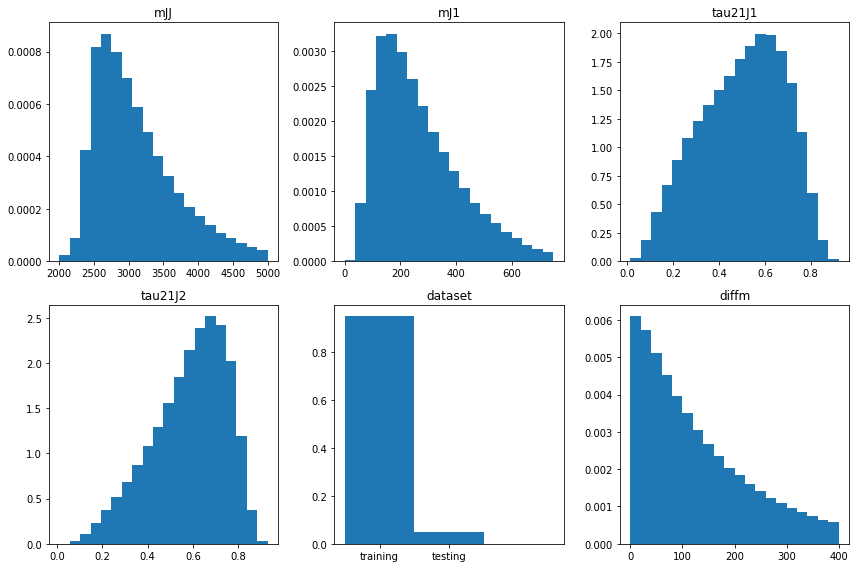

retrieved array of shape (588, 6)
           mJJ      mJ1   tau21J1   tau21J2   dataset     diffm
Event                                                          
16617  2328.29  502.652  0.059203  0.741238  training  382.3700
59906  2329.76  170.488  0.491438  0.196261  training   67.5050
17434  2438.02  539.559  0.206241  0.255750  training  439.0360
47859  2559.12  451.197  0.325897  0.584055  training  325.5760
98122  2755.21  416.224  0.174218  0.240144  training  322.4574


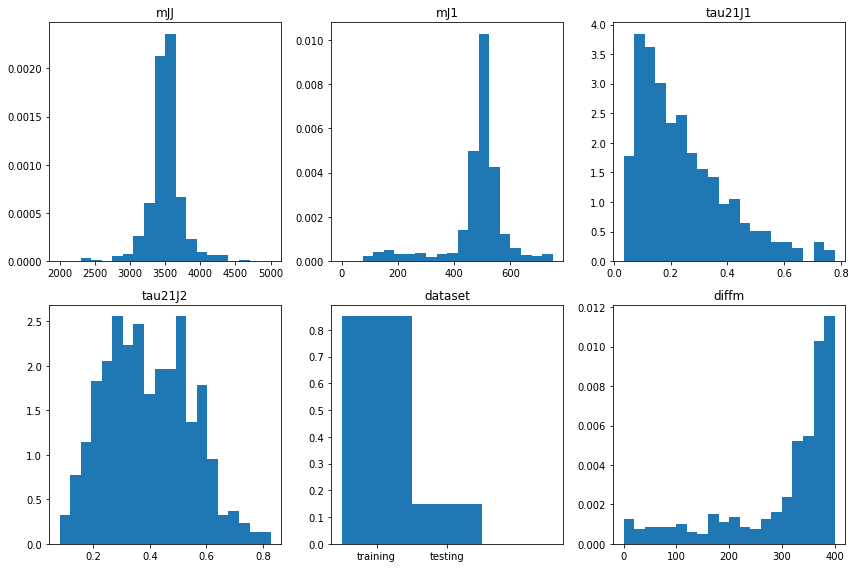

In [10]:
bkgname="rndbkgout.txt"
signame="rndsigout.txt"
bkglist=prepare_mother_list(bkgname, 500000, random_state=10, testratio=0.05)
siglist=prepare_mother_list(signame, 500, random_state=10, testratio=0.15)

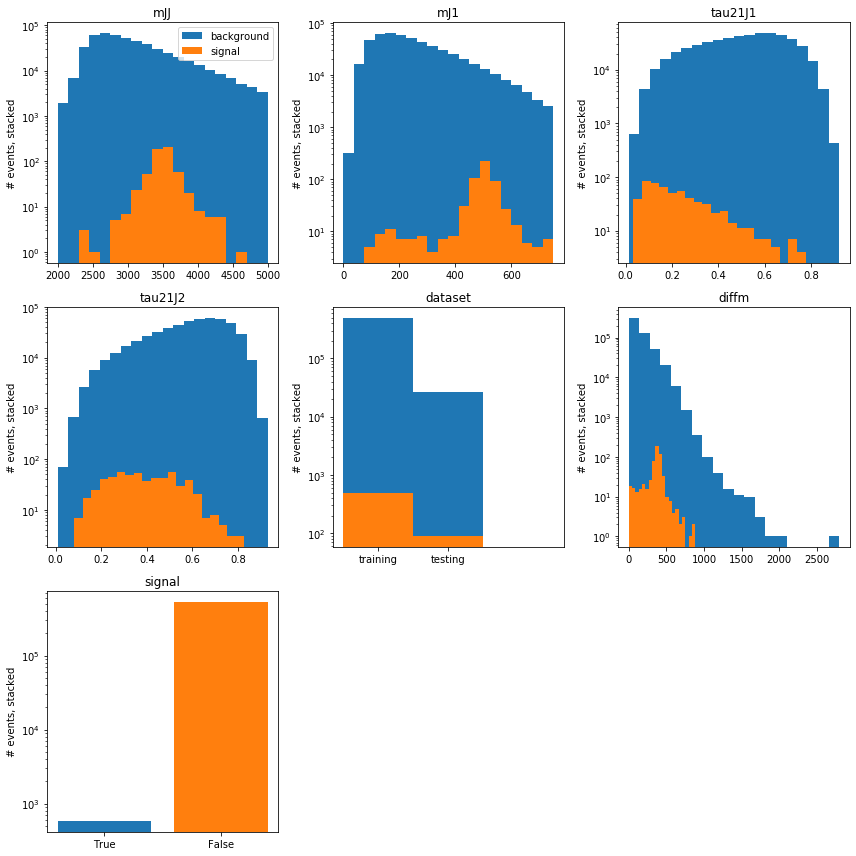

In [11]:
combined = combine_sig_bkg(siglist, bkglist)

In [12]:
Nsig_SR = combined.query('dataset == "training"').query('mJJ > 3300').query('mJJ < 3700').query('signal == 1').shape[0]
Nbkg_SR = combined.query('dataset == "training"').query('mJJ > 3300').query('mJJ < 3700').query('signal == 0').shape[0]
print('Nsig:', Nsig_SR)
print('Nbkg:', Nbkg_SR)
print('Nsig/Nbkg: {:.1e}'.format(Nsig_SR/Nbkg_SR))
print('Nsig/sqrt(Nbkg): {:.2f}'.format(Nsig_SR/np.sqrt(Nbkg_SR)))

Nsig: 376
Nbkg: 71330
Nsig/Nbkg: 5.3e-03
Nsig/sqrt(Nbkg): 1.41


Train on Signal Data

In [13]:
data_bkg_train, data_sig_train, _ = prepare_data_train(3500,200, 
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])

efficiency in SR when cutting edges of hypercube: 0.45


efficiency in SR when cutting edges of hypercube: 0.45
32384 events available for training
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
____________________________________

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_21 (Batc (None, 32)                128       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128 

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_41 (Batc (None, 32)                128       
_________________________________________________________________
dense_62 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_42 (Batc (None, 32)                128

Batch:   0 Loss = 8.339512e-02,
Batch:  10 Loss = -1.964805e+00,
Batch:  20 Loss = -2.676626e+00,
Batch:  30 Loss = -3.468251e+00,
Batch:  40 Loss = -3.817724e+00,
Batch:  50 Loss = -3.956842e+00,
Batch:  60 Loss = -4.283311e+00,
Batch:  70 Loss = -4.342179e+00,
Batch:  80 Loss = -4.228518e+00,
Batch:  90 Loss = -4.504468e+00,
Batch: 100 Loss = -4.315338e+00,
Batch: 110 Loss = -4.366895e+00,
Batch: 120 Loss = -4.661954e+00,
Epoch:   0 Loss = -4.833271e+00, testing-loss = -4.567777e+00
Batch:   0 Loss = -4.704078e+00,
Batch:  10 Loss = -5.019157e+00,
Batch:  20 Loss = -4.682690e+00,
Batch:  30 Loss = -4.686599e+00,
Batch:  40 Loss = -4.707114e+00,
Batch:  50 Loss = -4.661316e+00,
Batch:  60 Loss = -4.734144e+00,
Batch:  70 Loss = -4.817118e+00,
Batch:  80 Loss = -4.881210e+00,
Batch:  90 Loss = -4.980245e+00,
Batch: 100 Loss = -4.768142e+00,
Batch: 110 Loss = -4.735102e+00,
Batch: 120 Loss = -4.934796e+00,
Epoch:   1 Loss = -4.691483e+00, testing-loss = -4.799103e+00
Batch:   0 Loss = -

Batch: 110 Loss = -5.075260e+00,
Batch: 120 Loss = -5.010826e+00,
Epoch:  16 Loss = -4.985401e+00, testing-loss = -4.965743e+00
Batch:   0 Loss = -5.034740e+00,
Batch:  10 Loss = -5.120096e+00,
Batch:  20 Loss = -4.903866e+00,
Batch:  30 Loss = -5.003705e+00,
Batch:  40 Loss = -4.984653e+00,
Batch:  50 Loss = -4.896286e+00,
Batch:  60 Loss = -4.968357e+00,
Batch:  70 Loss = -5.053626e+00,
Batch:  80 Loss = -5.021587e+00,
Batch:  90 Loss = -5.095484e+00,
Batch: 100 Loss = -4.944579e+00,
Batch: 110 Loss = -5.029228e+00,
Batch: 120 Loss = -5.042378e+00,
Epoch:  17 Loss = -4.963939e+00, testing-loss = -4.963206e+00
Batch:   0 Loss = -4.942858e+00,
Batch:  10 Loss = -4.844932e+00,
Batch:  20 Loss = -5.011411e+00,
Batch:  30 Loss = -4.955641e+00,
Batch:  40 Loss = -5.144831e+00,
Batch:  50 Loss = -5.094651e+00,
Batch:  60 Loss = -5.004257e+00,
Batch:  70 Loss = -5.049134e+00,
Batch:  80 Loss = -4.831910e+00,
Batch:  90 Loss = -4.885562e+00,
Batch: 100 Loss = -4.943261e+00,
Batch: 110 Loss = 

Batch:  70 Loss = -5.054901e+00,
Batch:  80 Loss = -4.992449e+00,
Batch:  90 Loss = -4.894925e+00,
Batch: 100 Loss = -5.013141e+00,
Batch: 110 Loss = -5.015677e+00,
Batch: 120 Loss = -4.961111e+00,
Epoch:  33 Loss = -5.160586e+00, testing-loss = -4.975314e+00
Batch:   0 Loss = -5.050073e+00,
Batch:  10 Loss = -5.021548e+00,
Batch:  20 Loss = -4.932448e+00,
Batch:  30 Loss = -5.040521e+00,
Batch:  40 Loss = -4.864781e+00,
Batch:  50 Loss = -4.930483e+00,
Batch:  60 Loss = -5.006542e+00,
Batch:  70 Loss = -5.055422e+00,
Batch:  80 Loss = -5.144619e+00,
Batch:  90 Loss = -5.101834e+00,
Batch: 100 Loss = -5.024804e+00,
Batch: 110 Loss = -5.059506e+00,
Batch: 120 Loss = -4.974226e+00,
Epoch:  34 Loss = -5.004006e+00, testing-loss = -4.963254e+00
Batch:   0 Loss = -4.970789e+00,
Batch:  10 Loss = -5.027399e+00,
Batch:  20 Loss = -4.886102e+00,
Batch:  30 Loss = -5.004941e+00,
Batch:  40 Loss = -5.094490e+00,
Batch:  50 Loss = -5.015513e+00,
Batch:  60 Loss = -5.006023e+00,
Batch:  70 Loss = 

Batch:  30 Loss = -5.006503e+00,
Batch:  40 Loss = -5.120971e+00,
Batch:  50 Loss = -5.030027e+00,
Batch:  60 Loss = -5.078330e+00,
Batch:  70 Loss = -5.036919e+00,
Batch:  80 Loss = -5.058852e+00,
Batch:  90 Loss = -5.052771e+00,
Batch: 100 Loss = -4.927320e+00,
Batch: 110 Loss = -5.082793e+00,
Batch: 120 Loss = -5.021400e+00,
Epoch:  50 Loss = -5.020354e+00, testing-loss = -4.973957e+00
Batch:   0 Loss = -4.914085e+00,
Batch:  10 Loss = -5.104901e+00,
Batch:  20 Loss = -5.105453e+00,
Batch:  30 Loss = -5.208492e+00,
Batch:  40 Loss = -4.886841e+00,
Batch:  50 Loss = -5.157757e+00,
Batch:  60 Loss = -4.976132e+00,
Batch:  70 Loss = -5.087218e+00,
Batch:  80 Loss = -5.108607e+00,
Batch:  90 Loss = -5.029555e+00,
Batch: 100 Loss = -5.120873e+00,
Batch: 110 Loss = -4.916637e+00,
Batch: 120 Loss = -5.027245e+00,
Epoch:  51 Loss = -4.846358e+00, testing-loss = -4.974473e+00
Batch:   0 Loss = -5.109904e+00,
Batch:  10 Loss = -4.929493e+00,
Batch:  20 Loss = -5.089747e+00,
Batch:  30 Loss = 

Batch:  10 Loss = -5.026576e+00,
Batch:  20 Loss = -4.986578e+00,
Batch:  30 Loss = -5.003588e+00,
Batch:  40 Loss = -4.880917e+00,
Batch:  50 Loss = -4.907588e+00,
Batch:  60 Loss = -5.063222e+00,
Batch:  70 Loss = -4.959884e+00,
Batch:  80 Loss = -4.987378e+00,
Batch:  90 Loss = -5.145976e+00,
Batch: 100 Loss = -4.947603e+00,
Batch: 110 Loss = -5.023644e+00,
Batch: 120 Loss = -4.927942e+00,
Epoch:  67 Loss = -5.097595e+00, testing-loss = -4.961606e+00
Batch:   0 Loss = -4.906346e+00,
Batch:  10 Loss = -5.225354e+00,
Batch:  20 Loss = -4.942609e+00,
Batch:  30 Loss = -5.109072e+00,
Batch:  40 Loss = -4.824007e+00,
Batch:  50 Loss = -5.047240e+00,
Batch:  60 Loss = -4.967300e+00,
Batch:  70 Loss = -5.063280e+00,
Batch:  80 Loss = -5.025827e+00,
Batch:  90 Loss = -4.891560e+00,
Batch: 100 Loss = -5.123985e+00,
Batch: 110 Loss = -5.100016e+00,
Batch: 120 Loss = -4.995190e+00,
Epoch:  68 Loss = -4.945559e+00, testing-loss = -4.960495e+00
Batch:   0 Loss = -4.919231e+00,
Batch:  10 Loss = 

Batch: 120 Loss = -4.822012e+00,
Epoch:  83 Loss = -4.865475e+00, testing-loss = -4.904552e+00
Batch:   0 Loss = -4.922156e+00,
Batch:  10 Loss = -5.000069e+00,
Batch:  20 Loss = -5.008050e+00,
Batch:  30 Loss = -4.942195e+00,
Batch:  40 Loss = -5.004224e+00,
Batch:  50 Loss = -5.006089e+00,
Batch:  60 Loss = -4.956052e+00,
Batch:  70 Loss = -4.973839e+00,
Batch:  80 Loss = -4.924209e+00,
Batch:  90 Loss = -4.984310e+00,
Batch: 100 Loss = -5.084239e+00,
Batch: 110 Loss = -4.961379e+00,
Batch: 120 Loss = -4.910274e+00,
Epoch:  84 Loss = -4.997325e+00, testing-loss = -4.898199e+00
Batch:   0 Loss = -5.056384e+00,
Batch:  10 Loss = -4.993118e+00,
Batch:  20 Loss = -4.917749e+00,
Batch:  30 Loss = -4.786733e+00,
Batch:  40 Loss = -4.953222e+00,
Batch:  50 Loss = -5.040920e+00,
Batch:  60 Loss = -4.997722e+00,
Batch:  70 Loss = -4.920232e+00,
Batch:  80 Loss = -4.919421e+00,
Batch:  90 Loss = -4.879279e+00,
Batch: 100 Loss = -4.914471e+00,
Batch: 110 Loss = -4.815595e+00,
Batch: 120 Loss = 

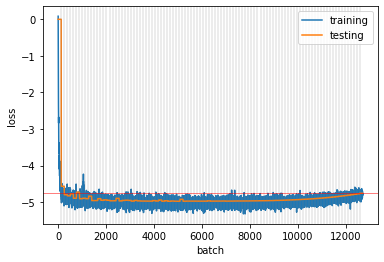

In [14]:
sigdist, losses =train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                             issig=True, batchsize=256, lr=1e-3, epochs=100,
                             weight_decay=1e-5)

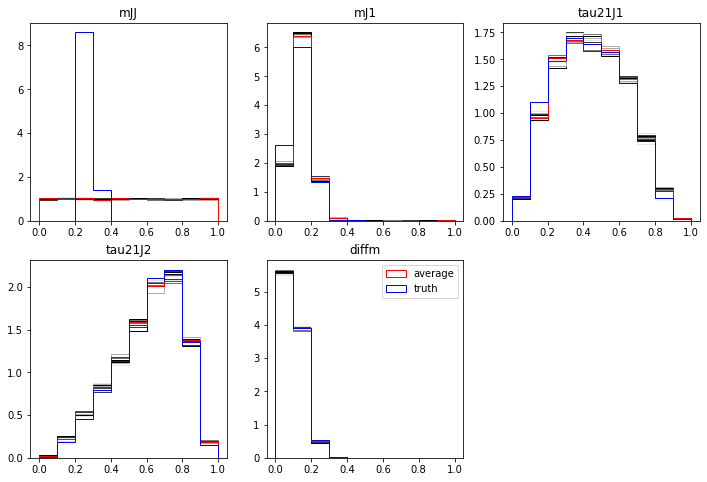

In [15]:
plot_learned_distributions(sigdist, 10000, data_sig_train.drop(columns='signal'))

Train on Background Data

efficiency in SR when cutting edges of hypercube: 0.45
167876 events available for training
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_192 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_128 (Bat (None, 32)                128       
_________________________________________________________________
dense_193 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_129 (Bat (None, 32)                128       
_________________________________________________________________
dense_194 (Dense)            (None, 32)                1056      
________________________________

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_228 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_152 (Bat (None, 32)                128       
_________________________________________________________________
dense_229 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_153 (Bat (None, 32)                128       
_________________________________________________________________
dense_230 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_154 (Bat (None, 32)                128

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_258 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_172 (Bat (None, 32)                128       
_________________________________________________________________
dense_259 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_173 (Bat (None, 32)                128       
_________________________________________________________________
dense_260 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_174 (Bat (None, 32)                128

running #2
running #3
running #3
Batch:   0 Loss = -4.204645e-02,
Batch:  10 Loss = -2.145746e+00,
Batch:  20 Loss = -3.149085e+00,
Batch:  30 Loss = -3.630576e+00,
Batch:  40 Loss = -3.807919e+00,
Batch:  50 Loss = -4.035022e+00,
Batch:  60 Loss = -4.271869e+00,
Batch:  70 Loss = -4.531125e+00,
Batch:  80 Loss = -4.767564e+00,
Batch:  90 Loss = -4.417929e+00,
Batch: 100 Loss = -5.169736e+00,
Batch: 110 Loss = -5.033191e+00,
Batch: 120 Loss = -4.729311e+00,
Batch: 130 Loss = -5.036939e+00,
Batch: 140 Loss = -4.901657e+00,
Batch: 150 Loss = -5.059635e+00,
Batch: 160 Loss = -5.195637e+00,
Batch: 170 Loss = -5.154737e+00,
Batch: 180 Loss = -5.097107e+00,
Batch: 190 Loss = -5.122431e+00,
Batch: 200 Loss = -5.048048e+00,
Batch: 210 Loss = -5.093986e+00,
Batch: 220 Loss = -5.253528e+00,
Batch: 230 Loss = -5.135196e+00,
Batch: 240 Loss = -5.005431e+00,
Batch: 250 Loss = -5.035621e+00,
Batch: 260 Loss = -5.017350e+00,
Batch: 270 Loss = -5.310542e+00,
Batch: 280 Loss = -5.141207e+00,
Batch: 290

Batch: 440 Loss = -5.181259e+00,
Batch: 450 Loss = -5.354636e+00,
Batch: 460 Loss = -5.206193e+00,
Batch: 470 Loss = -5.355102e+00,
Batch: 480 Loss = -5.323757e+00,
Batch: 490 Loss = -5.364399e+00,
Batch: 500 Loss = -5.236430e+00,
Batch: 510 Loss = -5.415790e+00,
Batch: 520 Loss = -5.233884e+00,
Batch: 530 Loss = -5.408431e+00,
Batch: 540 Loss = -5.344621e+00,
Batch: 550 Loss = -5.406046e+00,
Batch: 560 Loss = -5.308724e+00,
Batch: 570 Loss = -5.160884e+00,
Batch: 580 Loss = -5.105936e+00,
Batch: 590 Loss = -5.265281e+00,
Batch: 600 Loss = -5.280109e+00,
Batch: 610 Loss = -5.329034e+00,
Batch: 620 Loss = -5.447919e+00,
Batch: 630 Loss = -5.451283e+00,
Batch: 640 Loss = -5.394073e+00,
Batch: 650 Loss = -5.198786e+00,
Epoch:   3 Loss = -5.207923e+00, testing-loss = -5.282645e+00
Batch:   0 Loss = -5.149702e+00,
Batch:  10 Loss = -5.458545e+00,
Batch:  20 Loss = -5.224659e+00,
Batch:  30 Loss = -5.273458e+00,
Batch:  40 Loss = -5.370954e+00,
Batch:  50 Loss = -5.206916e+00,
Batch:  60 Los

Batch: 210 Loss = -5.296262e+00,
Batch: 220 Loss = -5.387098e+00,
Batch: 230 Loss = -5.212294e+00,
Batch: 240 Loss = -5.405955e+00,
Batch: 250 Loss = -5.331348e+00,
Batch: 260 Loss = -5.316298e+00,
Batch: 270 Loss = -5.267051e+00,
Batch: 280 Loss = -5.474690e+00,
Batch: 290 Loss = -5.304175e+00,
Batch: 300 Loss = -5.252053e+00,
Batch: 310 Loss = -5.307523e+00,
Batch: 320 Loss = -5.527328e+00,
Batch: 330 Loss = -5.369362e+00,
Batch: 340 Loss = -5.421649e+00,
Batch: 350 Loss = -5.365520e+00,
Batch: 360 Loss = -5.353073e+00,
Batch: 370 Loss = -5.313470e+00,
Batch: 380 Loss = -5.434729e+00,
Batch: 390 Loss = -5.415244e+00,
Batch: 400 Loss = -5.405433e+00,
Batch: 410 Loss = -5.391606e+00,
Batch: 420 Loss = -5.280895e+00,
Batch: 430 Loss = -5.270620e+00,
Batch: 440 Loss = -5.324525e+00,
Batch: 450 Loss = -5.274830e+00,
Batch: 460 Loss = -5.314168e+00,
Batch: 470 Loss = -5.514012e+00,
Batch: 480 Loss = -5.169297e+00,
Batch: 490 Loss = -5.315953e+00,
Batch: 500 Loss = -5.238969e+00,
Batch: 510

Epoch:  10 Loss = -5.182361e+00, testing-loss = -5.321127e+00
Batch:   0 Loss = -5.382197e+00,
Batch:  10 Loss = -5.115781e+00,
Batch:  20 Loss = -5.260553e+00,
Batch:  30 Loss = -5.414613e+00,
Batch:  40 Loss = -5.305036e+00,
Batch:  50 Loss = -5.352562e+00,
Batch:  60 Loss = -5.101607e+00,
Batch:  70 Loss = -5.199603e+00,
Batch:  80 Loss = -5.351671e+00,
Batch:  90 Loss = -5.136384e+00,
Batch: 100 Loss = -5.346305e+00,
Batch: 110 Loss = -5.128339e+00,
Batch: 120 Loss = -5.237329e+00,
Batch: 130 Loss = -5.255480e+00,
Batch: 140 Loss = -5.293282e+00,
Batch: 150 Loss = -5.279025e+00,
Batch: 160 Loss = -5.252218e+00,
Batch: 170 Loss = -5.323004e+00,
Batch: 180 Loss = -5.262032e+00,
Batch: 190 Loss = -5.306570e+00,
Batch: 200 Loss = -5.296588e+00,
Batch: 210 Loss = -5.395880e+00,
Batch: 220 Loss = -5.427280e+00,
Batch: 230 Loss = -5.380309e+00,
Batch: 240 Loss = -5.328309e+00,
Batch: 250 Loss = -5.303363e+00,
Batch: 260 Loss = -5.355734e+00,
Batch: 270 Loss = -5.294709e+00,
Batch: 280 Los

Batch: 430 Loss = -5.305001e+00,
Batch: 440 Loss = -5.371616e+00,
Batch: 450 Loss = -5.220464e+00,
Batch: 460 Loss = -5.305535e+00,
Batch: 470 Loss = -5.338152e+00,
Batch: 480 Loss = -5.280024e+00,
Batch: 490 Loss = -5.320799e+00,
Batch: 500 Loss = -5.127042e+00,
Batch: 510 Loss = -5.183891e+00,
Batch: 520 Loss = -5.205209e+00,
Batch: 530 Loss = -5.244731e+00,
Batch: 540 Loss = -5.226982e+00,
Batch: 550 Loss = -5.208751e+00,
Batch: 560 Loss = -5.299817e+00,
Batch: 570 Loss = -5.334017e+00,
Batch: 580 Loss = -5.458388e+00,
Batch: 590 Loss = -5.323388e+00,
Batch: 600 Loss = -5.301610e+00,
Batch: 610 Loss = -5.045301e+00,
Batch: 620 Loss = -5.382819e+00,
Batch: 630 Loss = -5.308681e+00,
Batch: 640 Loss = -5.386235e+00,
Batch: 650 Loss = -5.256020e+00,
Epoch:  14 Loss = -5.292814e+00, testing-loss = -5.290147e+00
Batch:   0 Loss = -5.219896e+00,
Batch:  10 Loss = -5.321553e+00,
Batch:  20 Loss = -5.138085e+00,
Batch:  30 Loss = -5.280822e+00,
Batch:  40 Loss = -5.367202e+00,
Batch:  50 Los

Batch: 200 Loss = -5.028589e+00,
Batch: 210 Loss = -5.210000e+00,
Batch: 220 Loss = -5.113381e+00,
Batch: 230 Loss = -5.038127e+00,
Batch: 240 Loss = -5.026886e+00,
Batch: 250 Loss = -5.132003e+00,
Batch: 260 Loss = -5.063162e+00,
Batch: 270 Loss = -5.167663e+00,
Batch: 280 Loss = -5.104869e+00,
Batch: 290 Loss = -5.123040e+00,
Batch: 300 Loss = -5.205192e+00,
Batch: 310 Loss = -5.188967e+00,
Batch: 320 Loss = -5.032937e+00,
Batch: 330 Loss = -4.998228e+00,
Batch: 340 Loss = -5.091349e+00,
Batch: 350 Loss = -5.057431e+00,
Batch: 360 Loss = -5.267155e+00,
Batch: 370 Loss = -5.051956e+00,
Batch: 380 Loss = -5.170996e+00,
Batch: 390 Loss = -5.048824e+00,
Batch: 400 Loss = -5.034297e+00,
Batch: 410 Loss = -4.992015e+00,
Batch: 420 Loss = -5.185283e+00,
Batch: 430 Loss = -5.189682e+00,
Batch: 440 Loss = -5.158245e+00,
Batch: 450 Loss = -5.192334e+00,
Batch: 460 Loss = -5.042425e+00,
Batch: 470 Loss = -5.032990e+00,
Batch: 480 Loss = -4.921829e+00,
Batch: 490 Loss = -5.093598e+00,
Batch: 500

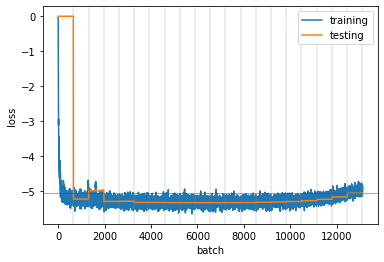

In [18]:
bkgdist, losses = train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                              issig=False, batchsize=256, lr=1e-3, epochs=20,
                              weight_decay=1e-5) #do not use learning rate schedule

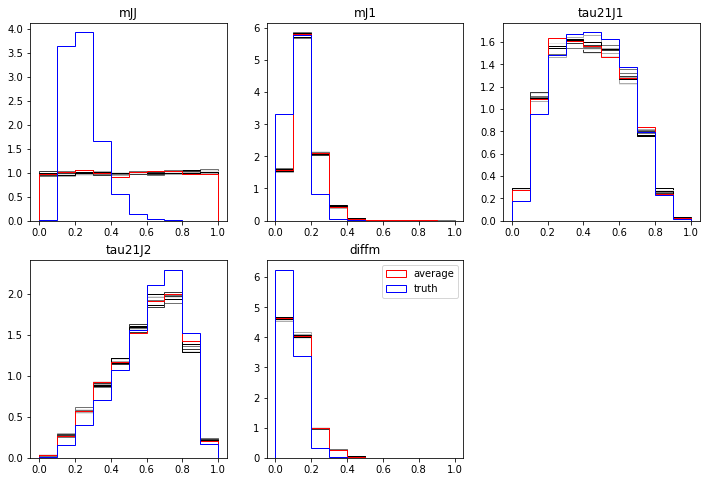

In [19]:
plot_learned_distributions(bkgdist, 10000, data_bkg_train.drop(columns='signal'))

Calculating R

In [46]:
combined.signal = combined.signal.astype(float)
data_bkg, data_sig, invM = prepare_data_train(3500,200, 
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])
data_sig = tf.convert_to_tensor(data_sig.values)
data_bkg = tf.convert_to_tensor(data_bkg.values)

efficiency in SR when cutting edges of hypercube: 0.45


In [34]:
#mixed = tfd.Mixture(cat=tfd.Categorical(probs=[1./len(sigdist)]*len(sigdist)),
#                    components=list(sigdist))
#print(mixed.sample(1))
#mixed.prob(mixed.sample(1))

# since the commented part raises an exception, this is a temporary workaround.
def get_prob(dists, sample):
    # turn sample into DataFrame
    sample = pd.DataFrame(sample.numpy())
    
    # assign a random distribution to each data point
    sample['dist_no'] = np.random.randint(len(dists), size=len(sample))
    
    # get the probabilities
    sample['prob'] = 0.
    for i in range(len(dists)):
        sample.loc[sample.dist_no == i, 'prob'] = dists[i].prob(sample[sample.dist_no == i].drop(columns=['dist_no', 'prob']).values).numpy()
    return tf.convert_to_tensor(sample.prob.values)
    
bkgprob = get_prob(bkgdist, data_sig[:, :5])
# bkgprob=bkgdist[-1].prb(data_sig[:, :5])
sigprob = get_prob(sigdist, data_sig[:, :5])
# sigprob=sigdist[-1].prob(data_sig[:, :5])
bkglogprob=np.log(bkgprob)

In [47]:
bkgprob = bkgdist[-8].prob(data_sig[:, :5])
bkglogprob = np.log(bkgprob)

cast back into pandas DataFrames

In [48]:
data_sig = pd.DataFrame(data_sig.numpy(), columns=['mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2', 'signal'])
data_sig.signal = (data_sig.signal - np.min(data_sig.signal)).astype('bool')
data_sig['sigprob'] = sigprob.numpy()
data_sig['bkgprob'] = bkgprob.numpy()
data_sig['bkglogprob'] = np.log(data_sig['bkgprob'])
data_sig['R'] = data_sig.sigprob/data_sig.bkgprob
data_sig['mJJ_unscaled'] = invM
data_sig.sort_values(by='R', ascending=True, inplace=True)
issignal = data_sig.signal

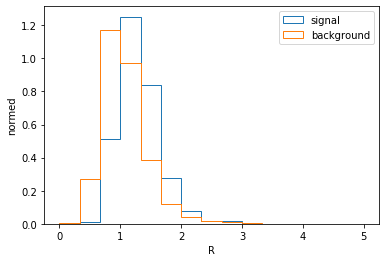

In [49]:
plt.hist(data_sig[issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='signal')
plt.hist(data_sig[~issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='background')
plt.xlabel('R')
plt.ylabel('normed')
plt.legend()
plt.savefig('R_distribution.png')
plt.show()

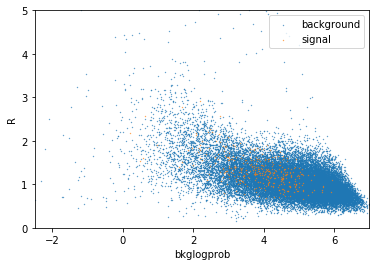

In [50]:
plt.scatter(data_sig[~issignal].bkglogprob, data_sig[~issignal].R, s=0.1, label='background')
plt.scatter(data_sig[issignal].bkglogprob, data_sig[issignal].R, s=0.1, label='signal')
plt.ylim(0,5)
plt.xlim(-2.5,7)
plt.xlabel('bkglogprob')
plt.ylabel('R')
plt.legend()
plt.savefig('R_bkglogprob_scatter.png')
plt.show()

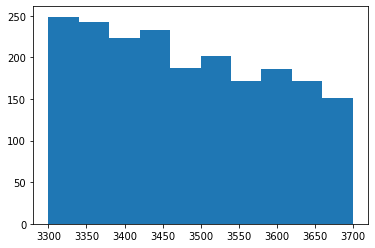

In [51]:
plt.hist(data_sig.query('R > 2.').mJJ_unscaled)
plt.show()

In [52]:
signals = data_sig[issignal].copy()
signals.sort_values(by='R', ascending=False, inplace=True)
signals['count'] = np.arange(len(signals))

backgrounds = data_sig[~issignal].copy()
backgrounds.sort_values(by='R', ascending=False, inplace=True)
backgrounds['count'] = np.arange(len(backgrounds))

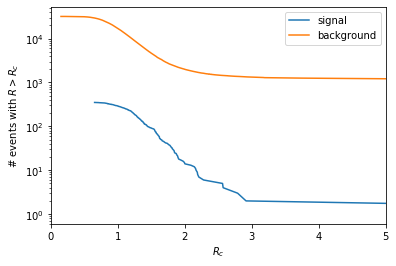

In [53]:
plt.plot(signals.R, signals['count'], label='signal')
plt.plot(backgrounds.R, backgrounds['count'], label='background')
plt.yscale('log')
plt.ylabel('# events with $R > R_c$')
plt.xlabel('$R_c$')
plt.xlim(0,5)
plt.legend()
plt.savefig('Events_vs_Rc.png')
plt.show()

In [54]:
effs = pd.DataFrame(np.linspace(0, 5, 50), columns=['Rmin'])
effs['sig_eff'] = effs.Rmin.transform(lambda x: len(signals.query('R > {}'.format(x)))/Nsig_SR)
effs['bkg_rej'] = effs.Rmin.transform(lambda x: Nbkg_SR/len(backgrounds.query('R > {}'.format(x))))
effs['s_over_sqrtb'] = effs.sig_eff * np.sqrt(effs.bkg_rej)

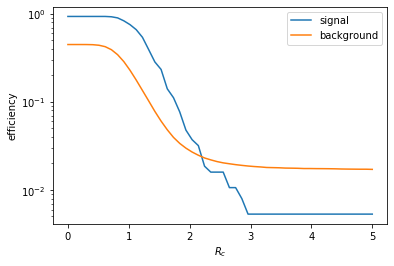

In [55]:
plt.plot(effs.Rmin, effs.sig_eff, label='signal')
plt.plot(effs.Rmin, 1/effs.bkg_rej, label='background')
plt.xlabel('$R_c$')
plt.ylabel('efficiency')
plt.yscale('log')
plt.legend()
plt.show()

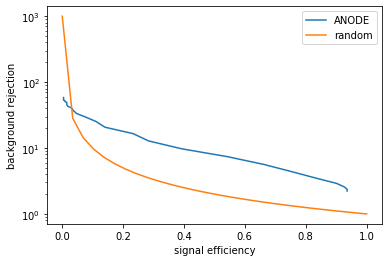

In [56]:
plt.plot(effs.sig_eff, effs.bkg_rej, label='ANODE')
plt.plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
plt.yscale('log')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend()
plt.savefig('ROC.png')
plt.show()

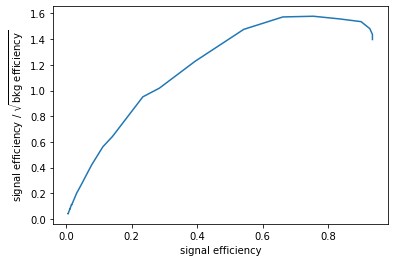

In [57]:
plt.plot(effs.sig_eff, effs.s_over_sqrtb)
plt.xlabel('signal efficiency')
plt.ylabel('signal efficiency / $\sqrt{\mathrm{bkg~efficiency}}$')
plt.show()

In [71]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

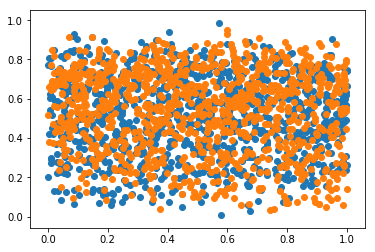

In [74]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [36]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

NameError: name 'training_data_sampled' is not defined